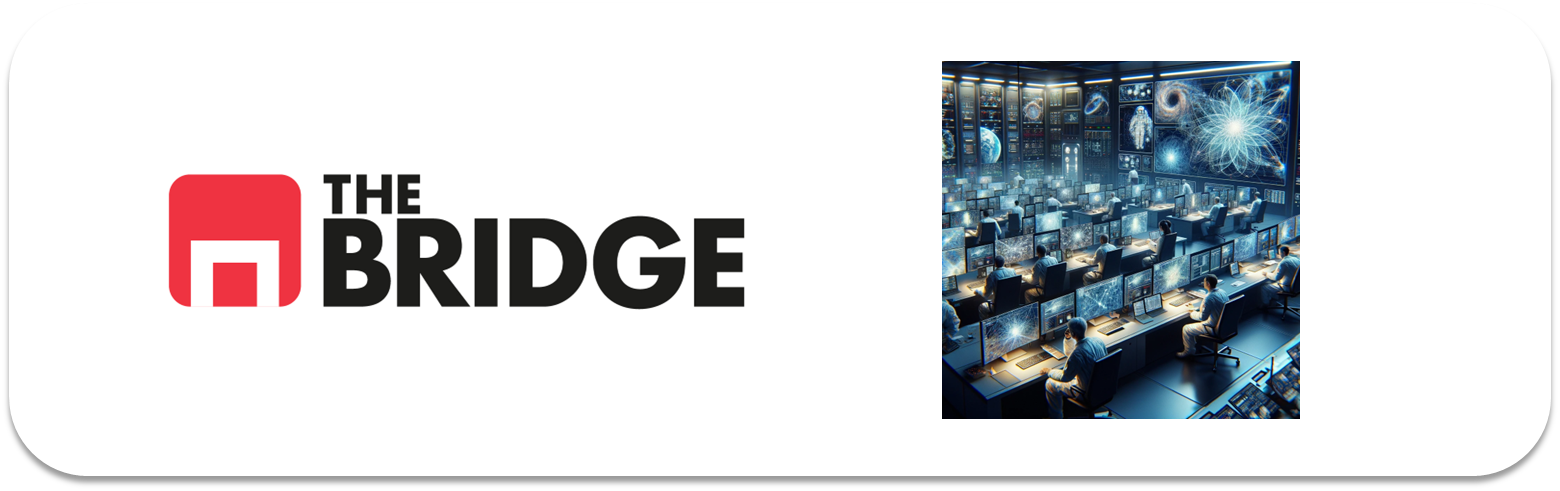

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [38]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

import warnings
# filter warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



In [39]:
import os
print(os.listdir('data/github_train_0'))

['cat.3406.jpg', 'cat.3374.jpg', 'cat.1205.jpg', 'cat.3412.jpg', 'cat.985.jpg', 'cat.588.jpg', 'cat.1775.jpg', 'cat.1991.jpg', 'cat.3638.jpg', 'cat.1985.jpg', 'cat.3764.jpg', 'cat.1173.jpg', 'cat.3002.jpg', 'cat.2334.jpg', 'cat.3758.jpg', 'cat.1629.jpg', 'cat.359.jpg', 'cat.1826.jpg', 'cat.365.jpg', 'cat.2491.jpg', 'cat.371.jpg', 'cat.417.jpg', 'cat.2678.jpg', 'cat.30.jpg', 'cat.629.jpg', 'cat.18.jpg', 'cat.3599.jpg', 'cat.2692.jpg', 'cat.628.jpg', 'cat.25.jpg', 'cat.2645.jpg', 'cat.1416.jpg', 'cat.10030.jpg', 'cat.1364.jpg', 'cat.10024.jpg', 'cat.3573.jpg', 'cat.370.jpg', 'cat.2447.jpg', 'cat.1628.jpg', 'cat.2321.jpg', 'cat.2335.jpg', 'cat.2453.jpg', 'cat.1166.jpg', 'cat.562.jpg', 'cat.1947.jpg', 'cat.2255.jpg', 'cat.2241.jpg', 'cat.1748.jpg', 'cat.1774.jpg', 'cat.774.jpg', 'cat.2080.jpg', 'cat.2916.jpg', 'cat.7.jpg', 'cat.2057.jpg', 'cat.1238.jpg', 'cat.2731.jpg', 'cat.2725.jpg', 'cat.3375.jpg', 'cat.947.jpg', 'cat.3413.jpg', 'cat.1210.jpg', 'cat.2719.jpg', 'cat.1206.jpg', 'cat.3377.

In [40]:

# Part 1
def load_images_from_directory(directory, img_size=(32, 32)):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            label = 1 if 'dog' in filename.lower() else 0  # 1 perro, 0 gato
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

# Directories
train_dirs = [
    "data/github_train_0",
    "data/github_train_1",
    "data/github_train_2",
    "data/github_train_3"
]
test_dir = "data/github_test"

In [41]:
X_train_list, y_train_list = [], []

In [42]:
for directory in train_dirs:
    X_dir, y_dir = load_images_from_directory(directory)
    X_train_list.append(X_dir)
    y_train_list.append(y_dir)

X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)

# Leer datos de test
X_test, y_test = load_images_from_directory(test_dir)

# Normalización de las imágenes (opcional pero recomendable)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4000, 32, 32, 3)
y_train shape: (4000,)
X_test shape: (1000, 32, 32, 3)
y_test shape: (1000,)


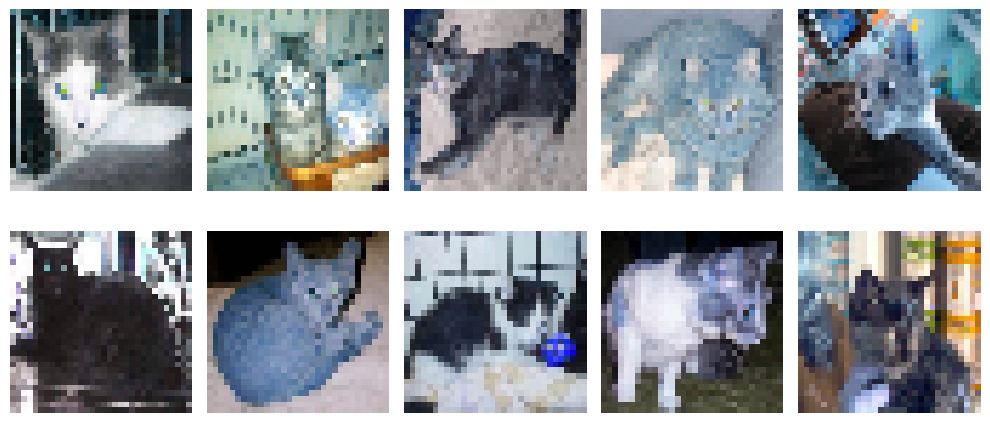

In [43]:
#Part 2 : MiniEda
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
axs = axs.flatten()

for img, ax in zip(X_train[:10], axs):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [44]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(2000), np.int64(1): np.int64(2000)}


In [45]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(2000), np.int64(1): np.int64(2000)}
{np.int64(0): np.int64(500), np.int64(1): np.int64(500)}


In [46]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [47]:
#Model 
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 314,945 (1.20 MB)

 Trainable params: 314,753 (1.20 MB)

 Non-trainable params: 192 (768.00 B)

In [54]:
#Part 3

# EarlyStopping:Si no mejora 'val_loss' durante 3 épocas consecutivas.
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True, 
    verbose=1
)

# Entrenamos el modelo con el callback
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6674 - loss: 0.5959 - val_accuracy: 0.5000 - val_loss: 0.6940
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7052 - loss: 0.5651 - val_accuracy: 0.5740 - val_loss: 0.6801
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7188 - loss: 0.5473 - val_accuracy: 0.6290 - val_loss: 0.6496
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7478 - loss: 0.5008 - val_accuracy: 0.5000 - val_loss: 1.7456
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7812 - loss: 0.4588 - val_accuracy: 0.7150 - val_loss: 0.5620
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8136 - loss: 0.4127 - val_accuracy: 0.5070 - val_loss: 1.5613
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8351 - loss: 0.3644 - val_accuracy: 0.5970 - val_loss: 0.9752
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8499 - loss: 0.3342 - val_accu

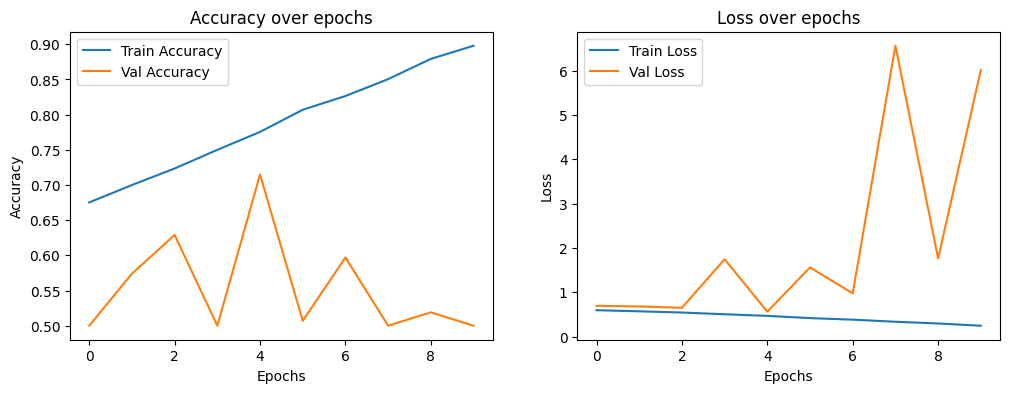

In [55]:


# Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()

plt.show()


In [56]:
#part 4
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7004 - loss: 0.5859
Test Accuracy: 0.7150


In [57]:

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).reshape(-1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))


              precision    recall  f1-score   support

         Cat       0.69      0.78      0.73       500
         Dog       0.74      0.65      0.70       500

    accuracy                           0.71      1000
   macro avg       0.72      0.72      0.71      1000
weighted avg       0.72      0.71      0.71      1000



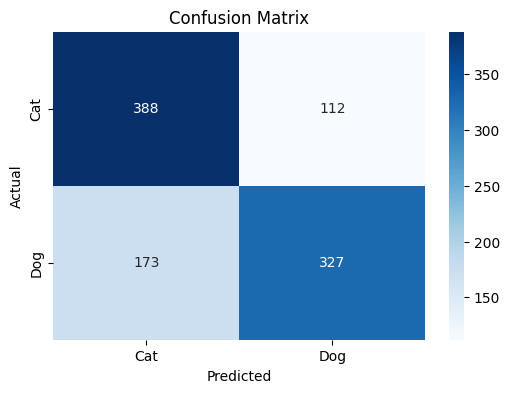

In [59]:

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#Mejorable pero por lo menos me capta los dos animales

In [ ]:
#Part 5


# Predictions and probabilities
y_probs = model.predict(X_test).flatten()

#Wrong images
wrong_cats = (y_test == 0) & (y_probs > 0.5)  # Gatos clasificados como perros
wrong_dogs = (y_test == 1) & (y_probs <= 0.5) # Perros clasificados como gatos

# 
# Gatos clasificados como perros (miramos la confianza alta en perro)
wrong_cats_idx = np.where(wrong_cats)[0]
wrong_cats_confidence = y_probs[wrong_cats_idx]
top_wrong_cats_idx = wrong_cats_idx[np.argsort(-wrong_cats_confidence)]

# Perros clasificados como gatos (miramos la confianza baja en perro)
wrong_dogs_idx = np.where(wrong_dogs)[0]
wrong_dogs_confidence = 1 - y_probs[wrong_dogs_idx]  # Confianza en gato
top_wrong_dogs_idx = wrong_dogs_idx[np.argsort(-wrong_dogs_confidence)]

# 10% of each
n_cats = max(1, len(top_wrong_cats_idx) // 10)
n_dogs = max(1, len(top_wrong_dogs_idx) // 10)

selected_cats = top_wrong_cats_idx[:n_cats]
selected_dogs = top_wrong_dogs_idx[:n_dogs]


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


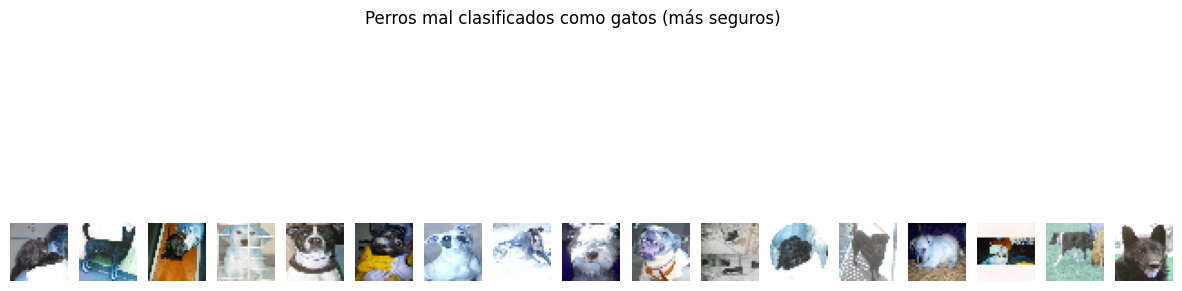

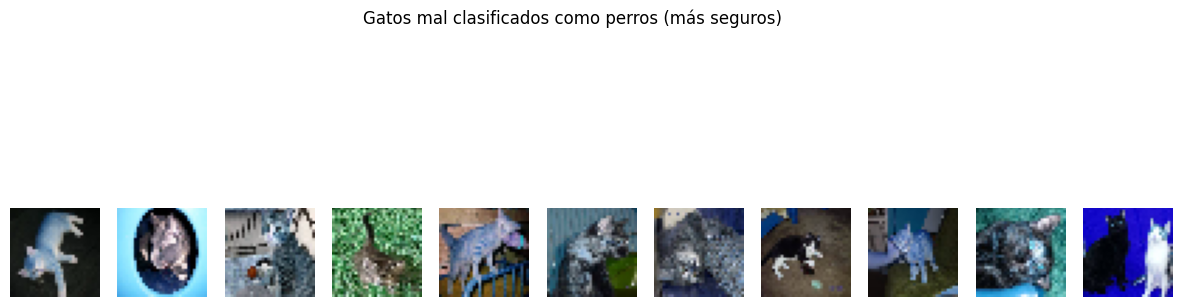

In [ ]:
def plot_images(X, idxs, title):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(idxs):
        plt.subplot(1, len(idxs), i + 1)
        plt.imshow(X[idx]* 255)#Recordar esto
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_images(X_test, selected_dogs, "Perros mal clasificados como gatos (más seguros)")
plot_images(X_test, selected_cats, "Gatos mal clasificados como perros (más seguros)")
